Imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum

## Aufgabe 2.1 - Value-Funktion für eine Grid-World Umgebung

Klassendefinition für das Grid:

In [2]:
class Direction(Enum):
    RIGHT = (0, 1)
    LEFT = (0, -1)
    UP = (-1, 0)
    DOWN = (1, 0)


class GridWorld:

    def __init__(self):
        state_dtype = np.dtype([('key', 'U2'), ('state_value', 'f4')])
        self.grid = np.array([[(None, 0) for _ in range(5)]
                             for _ in range(5)], dtype=state_dtype)
        self.grid[0, 1]['key'] = 'A'
        self.grid[0, 3]['key'] = 'B'
        self.grid[4, 1]['key'] = 'A_'
        self.grid[2, 3]['key'] = 'B_'

    def move(self, position, direction: Direction):
        # basically (pos[0]+dir[0], pos[1]+dir[1])
        new_position = tuple(sum(x) for x in zip(position, direction.value))

        if self.grid[position]['key'] == 'A':
            new_position = (4,1)
            return 10, new_position

        elif self.grid[position]['key'] == 'B':
            new_position = (2,3)
            return 5, new_position
        
        if new_position[0] < 0 or new_position[1] < 0 or new_position[0] > 4 or new_position[1] > 4:
            return -1, position
        else:
            return 0, new_position

        

### a) - State Values

Iterativer Algorithmus zur Bestimmung der State Values:

--- STATUS ---
Grid:
- - - - - - - - - - - - - - - - - - - - - - - - - 
| -0.5000 | 10.0000 |  2.0000 |  5.0000 |  0.6250 |
- - - - - - - - - - - - - - - - - - - - - - - - - 
| -0.3625 |  2.1684 |  0.9379 |  1.3360 |  0.1912 |
- - - - - - - - - - - - - - - - - - - - - - - - - 
| -0.3316 |  0.4133 |  0.3040 |  0.3690 | -0.1239 |
- - - - - - - - - - - - - - - - - - - - - - - - - 
| -0.3246 |  0.0200 |  0.0729 |  0.0994 | -0.2555 |
- - - - - - - - - - - - - - - - - - - - - - - - - 
| -0.5730 | -0.3744 | -0.3178 | -0.2991 | -0.6248 |
- - - - - - - - - - - - - - - - - - - - - - - - - 
Greatest value change compared to last iteration:
10.0
--- END STATUS ---

--- STATUS ---
Grid:
- - - - - - - - - - - - - - - - - - - - - - - - - 
|  1.4434 |  9.6630 |  3.7102 |  5.3321 |  1.0240 |
- - - - - - - - - - - - - - - - - - - - - - - - - 
|  0.4065 |  2.5697 |  1.7820 |  1.7267 |  0.3841 |
- - - - - - - - - - - - - - - - - - - - - - - - - 
| -0.2132 |  0.6031 |  0.6361 |  0.5261 | -0.1306 |
- - - - 

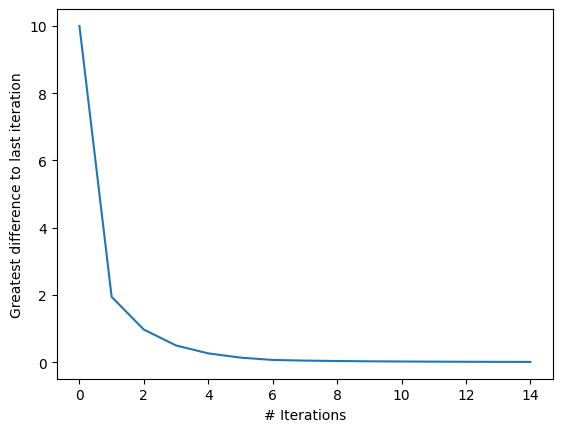

In [3]:
grid_world = GridWorld()
iterations = 15
discount = 0.9
diff_arr = []

def print_status(iteration):
    print('--- STATUS ---')
    print('Grid:')
    #print(np.array([[tup['state_value'] for tup in row] for row in grid_world.grid]))
    for row in grid_world.grid:
        print('- ' * len(grid_world.grid[0]) * 5)
        print('|', end='')
        for cell in row:
            cell_value = cell['state_value']

            # create equal spacing for printing    
            value_prefix = ' ' if cell_value > 0 else ''
            value_prefix = '' if cell_value >= 10 else value_prefix
            cell_value = round(cell_value, 4)
            print(f' {value_prefix}{cell_value:.4f} |', end='')
        
        print()
    print('- ' * len(grid_world.grid[0]) * 5)
    print('Greatest value change compared to last iteration:')
    print(diff_arr[iteration])
    print('--- END STATUS ---')
    print()

iterations_to_print = [0, 1, 5, iterations - 1]
for i in range(iterations):
    diff = 0
    for index, value in np.ndenumerate(grid_world.grid):
        new_value = 0
        for action in list(Direction):
            reward, next_state = grid_world.move(index, action)
            new_value += (1 / 4) * (reward + discount *
                                    grid_world.grid[next_state]['state_value'])
        
        new_diff = abs(new_value - value['state_value'])
        diff = max(diff, new_diff)

        value['state_value'] = new_value

    diff_arr.append(diff)
    if i in iterations_to_print:
        print_status(i)


plt.plot(diff_arr)
plt.xlabel('# Iterations')
plt.ylabel('Greatest difference to last iteration')
plt.show()

### b) - Action Values 

Betrachtung der Action-Values:

In [ ]:
grid_world = GridWorld()
iterations = 15
discount = 0.9
action_value_arr = np.zeros((5, 5, 4))
diff_arr = []

def action_value(action, state_index, action_value_arr):
    new_value = 0
    reward, next_state = grid_world.move(state_index, action)
    for i in range(len(Direction)):
        action_value_arr_index = next_state + (i,)
        new_value += 1 / 4 * (action_value_arr[action_value_arr_index])
    return reward + discount * new_value

for i in range(iterations):
    diff = 0
    for index, _ in np.ndenumerate(grid_world.grid):
        new_value = 0
        for j, action in enumerate(list(Direction)):
            new_value = action_value(action, index, action_value_arr)
            
            new_diff = abs(new_value - action_value_arr[index + (j,)])
            diff = max(diff, new_diff)
            
            action_value_arr[index + (j,)] = new_value
    
    diff_arr.append(diff)

plt.plot(diff_arr)
plt.xlabel('# Iterations')
plt.ylabel('Greatest difference to last iteration')
plt.show()

Print the final action values:

In [130]:
def print_grid(grid):
    for row in grid:
        print('- ' * len(grid[0]) * 5)
        print('|', end='')
        for cell in row:
            # create equal spacing for printing    
            value_prefix = ' ' if cell > 0 else ''
            value_prefix = '' if cell >= 10 else value_prefix
            print(f' {value_prefix}{cell:.4f} |', end='')
        
        print()
    print('- ' * len(grid[0]) * 5)

In [131]:
print('Final action values:', end='\n\n')

for index, _ in enumerate(list(Direction)):
    print(list(Direction)[index].name)
    print_grid(action_value_arr[:,:,index])
    print()

Final action values:

RIGHT
- - - - - - - - - - - - - - - - - - - - - - - - - 
|  7.9452 |  8.8207 |  4.8290 |  5.3574 |  0.3827 |
- - - - - - - - - - - - - - - - - - - - - - - - - 
|  2.7307 |  2.0623 |  1.7538 |  0.5298 | -0.4702 |
- - - - - - - - - - - - - - - - - - - - - - - - - 
|  0.7015 |  0.6414 |  0.3574 | -0.3280 | -1.3280 |
- - - - - - - - - - - - - - - - - - - - - - - - - 
| -0.3570 | -0.2863 | -0.4947 | -1.0328 | -2.0328 |
- - - - - - - - - - - - - - - - - - - - - - - - - 
| -1.1793 | -1.0768 | -1.2519 | -1.7493 | -2.7493 |
- - - - - - - - - - - - - - - - - - - - - - - - - 

LEFT
- - - - - - - - - - - - - - - - - - - - - - - - - 
|  2.0186 |  8.8207 |  7.9386 |  5.3574 |  4.8217 |
- - - - - - - - - - - - - - - - - - - - - - - - - 
|  0.4094 |  1.4040 |  2.7239 |  2.0555 |  1.7470 |
- - - - - - - - - - - - - - - - - - - - - - - - - 
| -0.9153 |  0.0793 |  0.6947 |  0.6348 |  0.3508 |
- - - - - - - - - - - - - - - - - - - - - - - - - 
| -1.8395 | -0.8447 | -0.3635 | -0.2926 

## Aufgabe 2.2 - OpenAI Gym: Implementieren der Grid-World:

In [ ]:
import gymnasium as gym
from gymnasium.envs.registration import register

### a) - Erstellung der Grid-World Umgebung

Erstellen der Umgebung, sie erbt von gym.Env:

In [ ]:
class GridWorldGym(gym.Env):

    metadata = {"render_modes": ["ascii"], "render_fps": 30}

    def __init__(self):
        super(GridWorldGym, self).__init__()
        self.action_space = gym.spaces.Discrete(4)
        """ 
        0 == UP
        1 == DOWN
        2 == LEFT
        3 == RIGHT 
        """
        self.observation_space = gym.spaces.Box(
            low=np.array([0, 0]), high=np.array([4, 4]), dtype=int)
        self.special_states = {
            'A': (0, 1),
            'B': (0, 3),
            'A_': (4, 1),
            'B_': (2, 3)
        }
        self.state = np.zeros((2), dtype=int)
        self.render_mode = 'ascii'

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Ruft die Basis-Reset-Funktion mit seed auf

        self.done = False
        self.state = np.zeros((2), dtype=int)
        return np.array(self.state), {}

    def step(self, action):
        done = False
        new_state = None
        reward = 0
        
        if action == 0:
            new_state = self.state + (-1, 0)
        elif action == 1:
            new_state = self.state + (1, 0)
        elif action == 2:
            new_state = self.state + (0, -1)
        elif action == 3:
            new_state = self.state + (0, 1)
        else:
            raise ValueError('Fehler')

        if new_state[0] < 0 or new_state[1] < 0 or new_state[0] > 4 or new_state[1] > 4:
            reward = -1
        # @Daniel: Du hast new_state gegen "A" und "B" vergliche und dann den reward gegeben und bist in "A" oder "B" geblieben. Sofern ich das richtig verstanden habe, passte das nicht ganz. Hab das jetzt so abgeändert, dass das wie oben ist und man quasi in A und B irgendeinen Move machen kann, die Belohnung erhält und nach A_ bzw. B_ verschoben wird 
        elif np.array_equal(self.state, self.special_states["A"]):
            reward = 10
            self.state = np.array(self.special_states["A_"])
            done = True
        elif np.array_equal(self.state, self.special_states["B"]):
            reward = 5
            self.state = np.array(self.special_states["B_"])
            done = True
        else:
            self.state = new_state

        return self.state, reward, done, False, {}
    
    def render(self):
        
        if self.render_mode != 'ascii':
            raise NotImplementedError

        render_str = ''
        for row_idx in range(5):
            render_str += '- ' * 16
            render_str += '\n'
            render_str += '|'
            for col_idx in range(5):
                render_str += ' '
                
                if np.array_equal(self.state, [row_idx, col_idx]):
                    render_str += 'X'
                else:
                    render_str += ' '

                if np.array_equal(self.special_states["A"], [row_idx, col_idx]):
                    render_str += 'A '
                elif np.array_equal(self.special_states["A_"], [row_idx, col_idx]):
                    render_str += 'A_'
                elif np.array_equal(self.special_states["B"], [row_idx, col_idx]):
                    render_str += 'B '
                elif np.array_equal(self.special_states["B_"], [row_idx, col_idx]):
                    render_str += 'B_'
                else:
                    render_str += '  '
                
                render_str += ' |'
            render_str += '\n'
        render_str += '- ' * 16
        render_str += '\nLegend: X = current state, A, B, A_, B_ = special states'

        return render_str

    
    def close(self):
        pass


Registrieren:

In [ ]:
register(
    id='GridWorldGym-v0',
    entry_point=GridWorldGym,
    max_episode_steps=1,
)

### b) - Testen der Grid-World Umgebung

In [ ]:
env = gym.make("GridWorldGym-v0")


total_reward = 0    # Gesamtbelohnung initialisieren
done = False

# speichert die Umgebungs-Visualisierung als Ascii-Strings
visualization = []

# Führe mehrere Schritte aus
while len(visualization) < 4:
    obs, info = env.reset()  # Setze die Umgebung zurück
    print(obs)

    while not done:
        action = env.action_space.sample()  # Wähle eine zufällige Aktion
        obs, reward, done, truncated, info = env.step(action)  # Führe die Aktion aus
        total_reward += reward  # Update die Gesamtbelohnung
        
        if len(visualization) < 4:
            visualization.append(env.render())

        print(f"Aktion: {action}, Neue Beobachtung: {obs}, Belohnung: {reward}, Done {done}")

print(f"Gesamtbelohnung nach der Episode: {total_reward}")

# Visualisierung von 4 aufeinanderfolgenden Schritten (mögliches Episodenende dazwischen)
for vis_index in range(len(visualization)):
    vis_string = visualization[vis_index]
    print(f'Step {vis_index}:')
    print(vis_string)

## Aufgabe 2.3 - CartPole Umgebung

Imports:

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

Einfache Visualisierung mit zufällig ausgewählten

In [ ]:
env = gym.make("CartPole-v1", render_mode="human")

visualization_iterations = 10

for _ in range(visualization_iterations):
    observation, info = env.reset()
    
    episode_over = False
    
    while not episode_over:
        action = env.action_space.sample()  # random right or left
        observation, reward, terminated, truncated, info = env.step(action)

        episode_over = terminated or truncated

env.close()

### b) - Implementierung eines intuitiven Lösungsansatzes

Environment setup:

In [ ]:
env = gym.make("CartPole-v1")

Config:

In [ ]:
runs = 100
num_episodes = 200

Policy 1: Wenn der Pole nach links geneigt ist, fahre nach links. Wenn der Pole nach rechts geneigt ist, fahre nach rechts.

In [ ]:
observation, info = env.reset()

rewards = np.zeros(num_episodes)

for _ in range(runs):
    
    for episode_index in range(num_episodes):

        observation, info = env.reset()

        episode_over = False
        episode_reward = 0

        while not episode_over:
            action = 1  # push cart to the right
            
            # if the pole is leaning to the left, push the cart to the left
            if observation[2] < 0:
                action = 0
            
            observation, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward

            episode_over = terminated or truncated
        
        rewards[episode_index] += episode_reward

rewards_p1 = np.divide(rewards, runs)

Policy 2: Wenn der Pole nach links geneigt ist aber eine positive Winkelgeschwindigkeit hat, fahre wieder nach rechts. Analog für Neigung nach rechts.

In [ ]:
observation, info = env.reset()

rewards = np.zeros(num_episodes)

for _ in range(runs):
    
    for episode_index in range(num_episodes):

        observation, info = env.reset()

        episode_over = False
        episode_reward = 0

        while not episode_over:
            action = 1  # push cart to the right
            
            # if the pole is leaning to the left, push the cart to the left
            falling_left = observation[3] < 0
            if falling_left:
                action = 0
            
            observation, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward

            episode_over = terminated or truncated
        
        rewards[episode_index] += episode_reward

rewards_p2 = np.divide(rewards, runs)

Policy 3: Zusätzliche Vermeidung des "Herausfahrens" aus der Umgebung:

In [ ]:
observation, info = env.reset()

rewards = np.zeros(num_episodes)

for _ in range(runs):

    for episode_index in range(num_episodes):

        observation, info = env.reset()

        episode_over = False
        episode_reward = 0

        while not episode_over:
            action = 1  # push cart to the right
            
            # if the pole is falling to the left, push the cart to the left
            # (falling meaning the angular velocity is negative)
            falling_left = observation[3] < 0
            if falling_left:
                action = 0
            
            # do not drive out of the environment
            cart_position = observation[0]
            if cart_position <= -2.2:
                action = 1
            elif cart_position >= 2.2:
                action = 0

            observation, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward

            episode_over = terminated or truncated

        rewards[episode_index] += episode_reward 

rewards_p3 = np.divide(rewards, runs)

Environment schließen:

In [ ]:
env.close()

Auswerten der Policy-Ergebnisse:

In [ ]:
x = np.linspace(0, num_episodes, num_episodes)

plt.plot(x, rewards_p1, label = 'Policy 1')
plt.plot(x, rewards_p2, label = 'Policy 2')
plt.plot(x, rewards_p3, label = 'Policy 3')
plt.xlabel('Episode')
plt.ylabel('Average Reward per Episode')
plt.legend()
plt.show()

### c) - RL-Ansatz

ObservationWrapper erstellen:

In [ ]:
import numpy as np

class DiscreteObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super(DiscreteObservationWrapper, self).__init__(env)
        self.pole_pos_bins = np.array([-np.inf, 0.0, np.inf])
        self.pole_vel_bins = np.array([-np.inf, 0.0, np.inf])
        self.num_states = 4
        
        self.min_state_idx = self.get_state_index(1, 1) # since the values are always greater than negative infinity, they are always in category 1 and never in zero. Thats why category tuple (1, 1) leads to the lowest individual state index

    def get_state_index(self, pole_pos_category, pole_vel_category):
        return 2 * pole_pos_category + pole_vel_category

    def observation(self, observation):
        _, _, pole_pos, pole_vel = observation
        
        pole_pos_category = np.digitize(pole_pos, self.pole_pos_bins)
        pole_vel_category = np.digitize(pole_vel, self.pole_vel_bins)

        # basically binary "or" operation, each category gets its own bit
        state_index = self.get_state_index(pole_pos_category, pole_vel_category)

        return state_index

Den Banditen durch eine Klasse modellieren:

In [ ]:
import numpy as np
import random

class StateBandit():
    def __init__(self, epsilon, initial_Q = 0.0):
        self.epsilon = epsilon
        self.Q = np.array([initial_Q, initial_Q])
        self.N = np.array([0, 0])
        self.G = 0
        self.reward_per_action = []

    def get_action(self):
        action = np.argmax(self.Q)

        # decide on exploit vs explore
        explore = random.random() <= self.epsilon
        if explore:
            action = int(random.random() >= 0.5)

        return action

    def update_metrics(self, action, reward):
        self.reward_per_action.append(reward)
        self.G += reward
        self.N[action] += 1
        self.Q[action] = self.Q[action] + ((reward - self.Q[action]) / self.N[action])

Für jeden State einen Banditen erstellen und die Simulation laufen lassen, um die Banditen anzulernen:

In [ ]:
from sys import stdout # flushing stdout for progress printing

# create env with wrapper
env = gym.make('CartPole-v1')
wrapped_env = DiscreteObservationWrapper(env)

# setting up the bandits
epsilon_value = 0.1
initial_Q = 1.0
bandits = [StateBandit(epsilon_value, initial_Q) for _ in range(wrapped_env.num_states)]

# training parameters
simulation_steps = 40_000

# reset wrapped env
state_index, _ = wrapped_env.reset()
episode_over = False

# training loop
progress = -1
sim_step = 0
while sim_step < simulation_steps:
    
    new_progress = int(((sim_step + 1) * 100) / simulation_steps)
    if new_progress > progress:
        progress = new_progress
        print(f'\rProgress: {progress} %', end='')
        stdout.flush()

    bandit_index = state_index - wrapped_env.min_state_idx
    action = bandits[bandit_index].get_action()
    state_index, reward, terminated, truncated, _ = wrapped_env.step(action)

    reward = -10 if terminated else reward

    bandits[bandit_index].update_metrics(action, reward)

    episode_over = terminated or truncated
    
    if episode_over:
        sim_step += 1
        episode_over = False
        state_index, _ = wrapped_env.reset()

Plotten des Lernprozesses, Nutzung eines "Dictionarys", Banditen-Index auf die Zustandsbeschreibung zu mappen. Die Verwendung eines vollwertigen Python-Dicts ist hier nicht notwendig, da die Banditen von Index 0 aufsteigend geplottet werden. Das heißt, man kann die Zustandsbeschreibungen auch chronologisch ablegen.

In [ ]:
state_index_description = ['Negative angle, negative velocity', 'Negative angle, positive velocity', 'Positive angle, Negative velocity', 'Positive angle, Positive velocity']

In [ ]:
fig, ax = plt.subplots(len(bandits), figsize=(15, 15))
for bandit_index in range(len(bandits)):
    bandit = bandits[bandit_index]
    ax[bandit_index].plot(bandit.reward_per_action, label = f'State {bandit_index} ({state_index_description[bandit_index]})')
    ax[bandit_index].set_xlabel('# Actions')
    ax[bandit_index].set_ylabel('Reward per Action')
    ax[bandit_index].legend()

plt.show()

Testen, wie gut die Banditen sind:

In [ ]:
num_episodes = 200
runs = 100

state_index, info = wrapped_env.reset()

rewards = np.zeros(num_episodes)

for _ in range(runs):
    
    for episode_index in range(num_episodes):

        state_index, info = wrapped_env.reset()

        episode_over = False
        episode_reward = 0

        while not episode_over:
            bandit_index = state_index - wrapped_env.min_state_idx
            action = bandits[bandit_index].get_action()

            state_index, reward, terminated, truncated, info = wrapped_env.step(action)
            episode_reward += reward

            episode_over = terminated or truncated
        
        rewards[episode_index] += episode_reward

rewards_RL = np.divide(rewards, runs)

Darstellung der Testergebnisse:

In [ ]:
x = np.linspace(0, num_episodes, num_episodes)

plt.plot(x, rewards_RL, label = 'Reinforcement Learning')
plt.xlabel('Episode')
plt.ylabel('Average Reward per Episode')
plt.ylim(0, 240)
plt.legend()
plt.show()

Schließen der Environments (Da diese noch für den Test verwendet wurden, kann man sie nicht direkt nach dem Training schließen):

In [ ]:
wrapped_env.close()
env.close()